# ベイズ回帰
リンク関数、線形予測子、回帰の書き方　etc. etc..

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# cpu がどんな感じで動いているか？
jax.devices()

[CpuDevice(id=0)]

In [3]:
df = pd.DataFrame({
    'gas': [1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.861, 1.8839],
    'beetles': [59, 60, 62, 56, 63, 59, 62, 60],
    'deaths': [6, 13, 18, 28, 52, 53, 61, 60]
})

Text(0, 0.5, 'Death Rate')

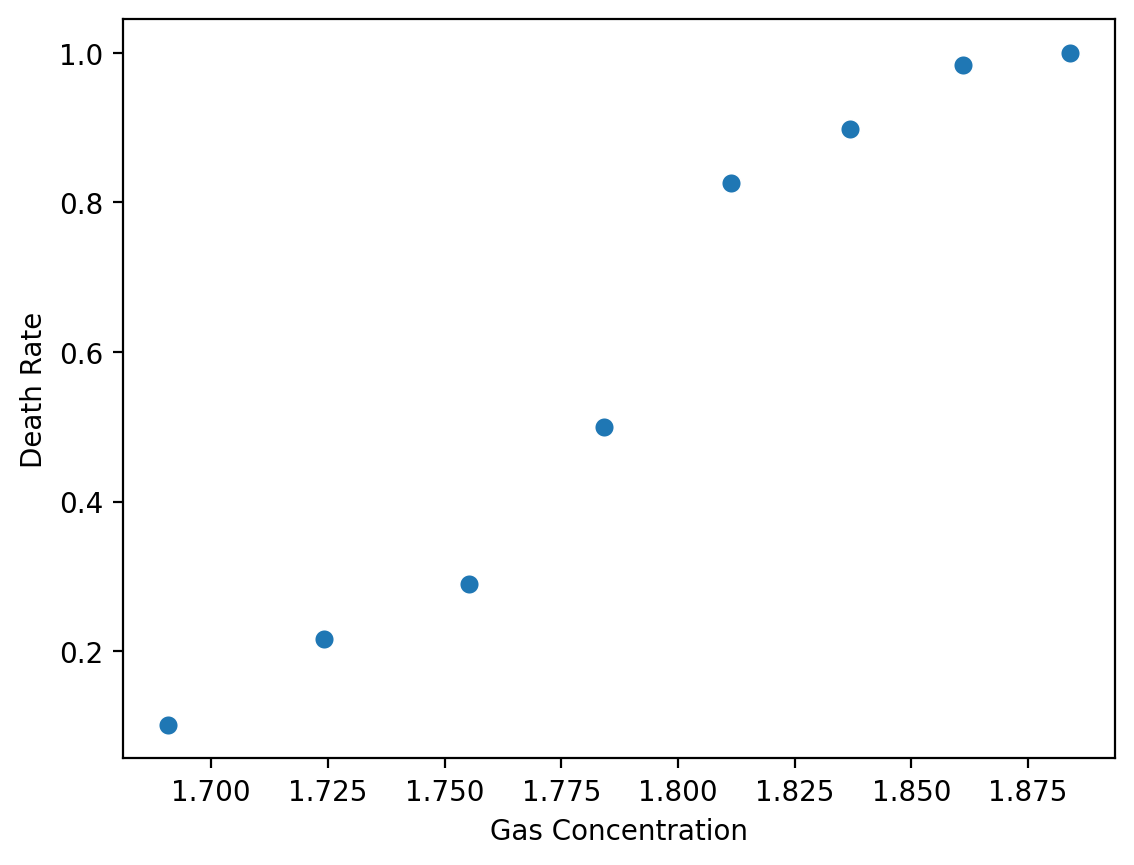

In [5]:
sns.scatterplot(x = df['gas'], y = df['deaths'] / df['beetles'], s = 50)

plt.xlabel("Gas Concentration")
plt.ylabel("Death Rate")

In [6]:
gas = df['gas'].values
deaths = df['deaths'].values
beetles = df['beetles'].values

In [7]:
gas_mu = np.mean(gas)
gas_sd = np.std(gas)

gas_scaled = (gas - gas_mu) / gas_sd

In [8]:
def model(gas_scaled = None, deaths = None, beetles = None, num_data = 0):

    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10))

    mu = a * gas_scaled + b
    theta = jax.nn.sigmoid(mu)

    with numpyro.plate('plate_obs', num_data):
        numpyro.sample('obs', dist.Binomial(total_count = beetles, probs = theta), obs = deaths)

In [9]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(42), gas_scaled = gas_scaled, deaths = deaths, beetles = beetles, num_data = len(gas_scaled))
mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_96249/3031639514.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:01<00:00,
sample: 100%|█| 3500/3500 [00:00<00:00,
sample: 100%|█| 3500/3500 [00:00<00:00,
sample: 100%|█| 3500/3500 [00:00<00:00,


In [10]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

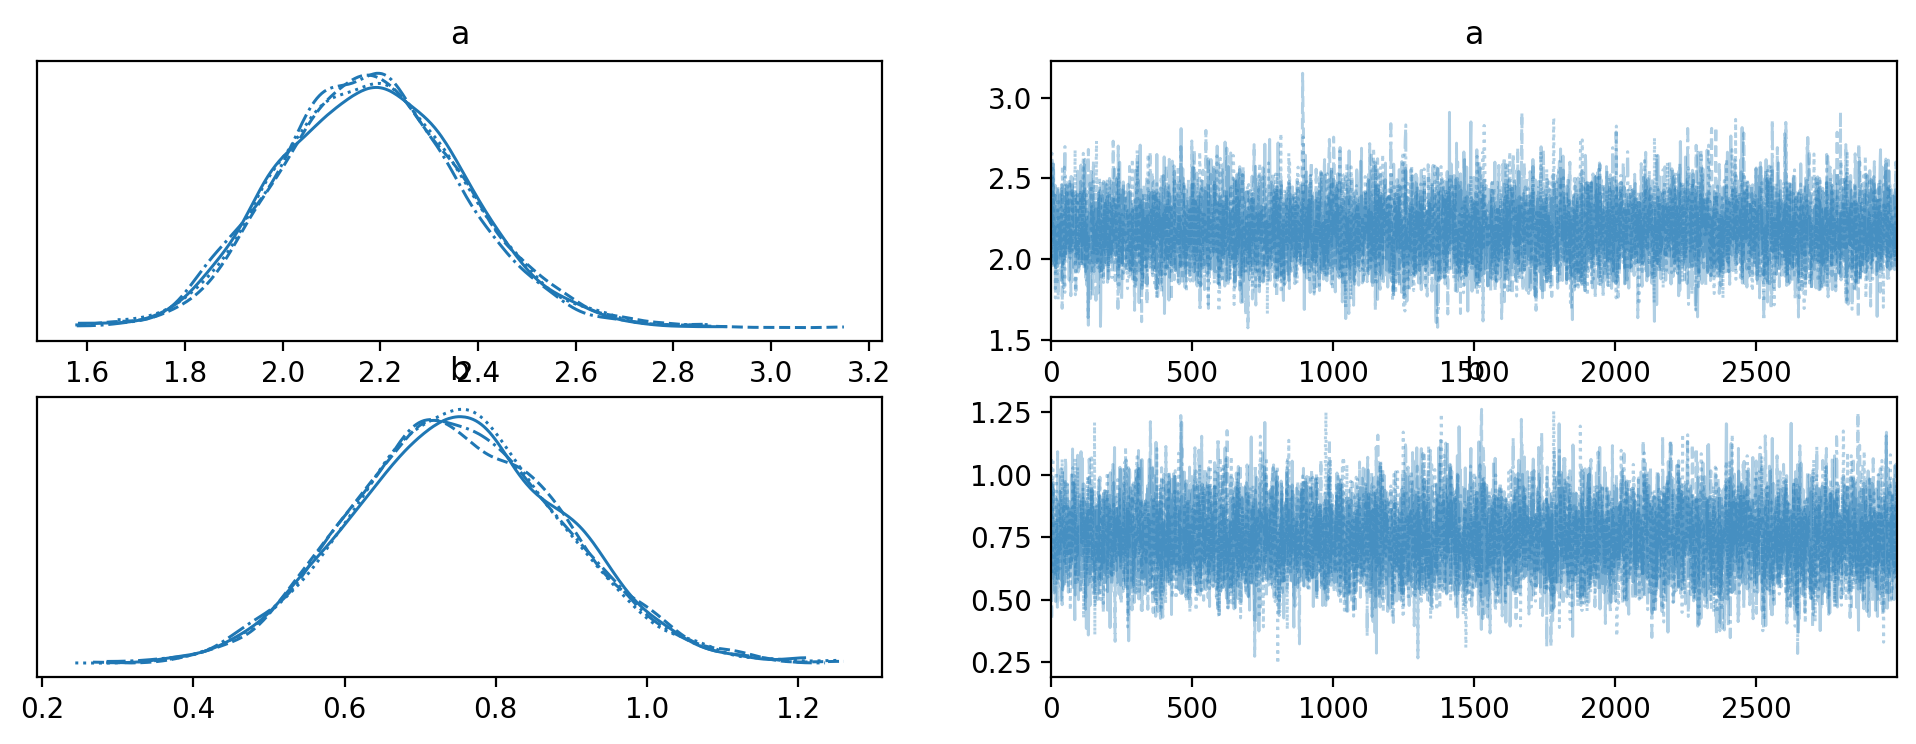

In [12]:
az.plot_trace(idata)

In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.181,0.188,1.831,2.528,0.002,0.002,6866.0,6529.0,1.0
b,0.749,0.139,0.497,1.017,0.002,0.001,6624.0,6504.0,1.0


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

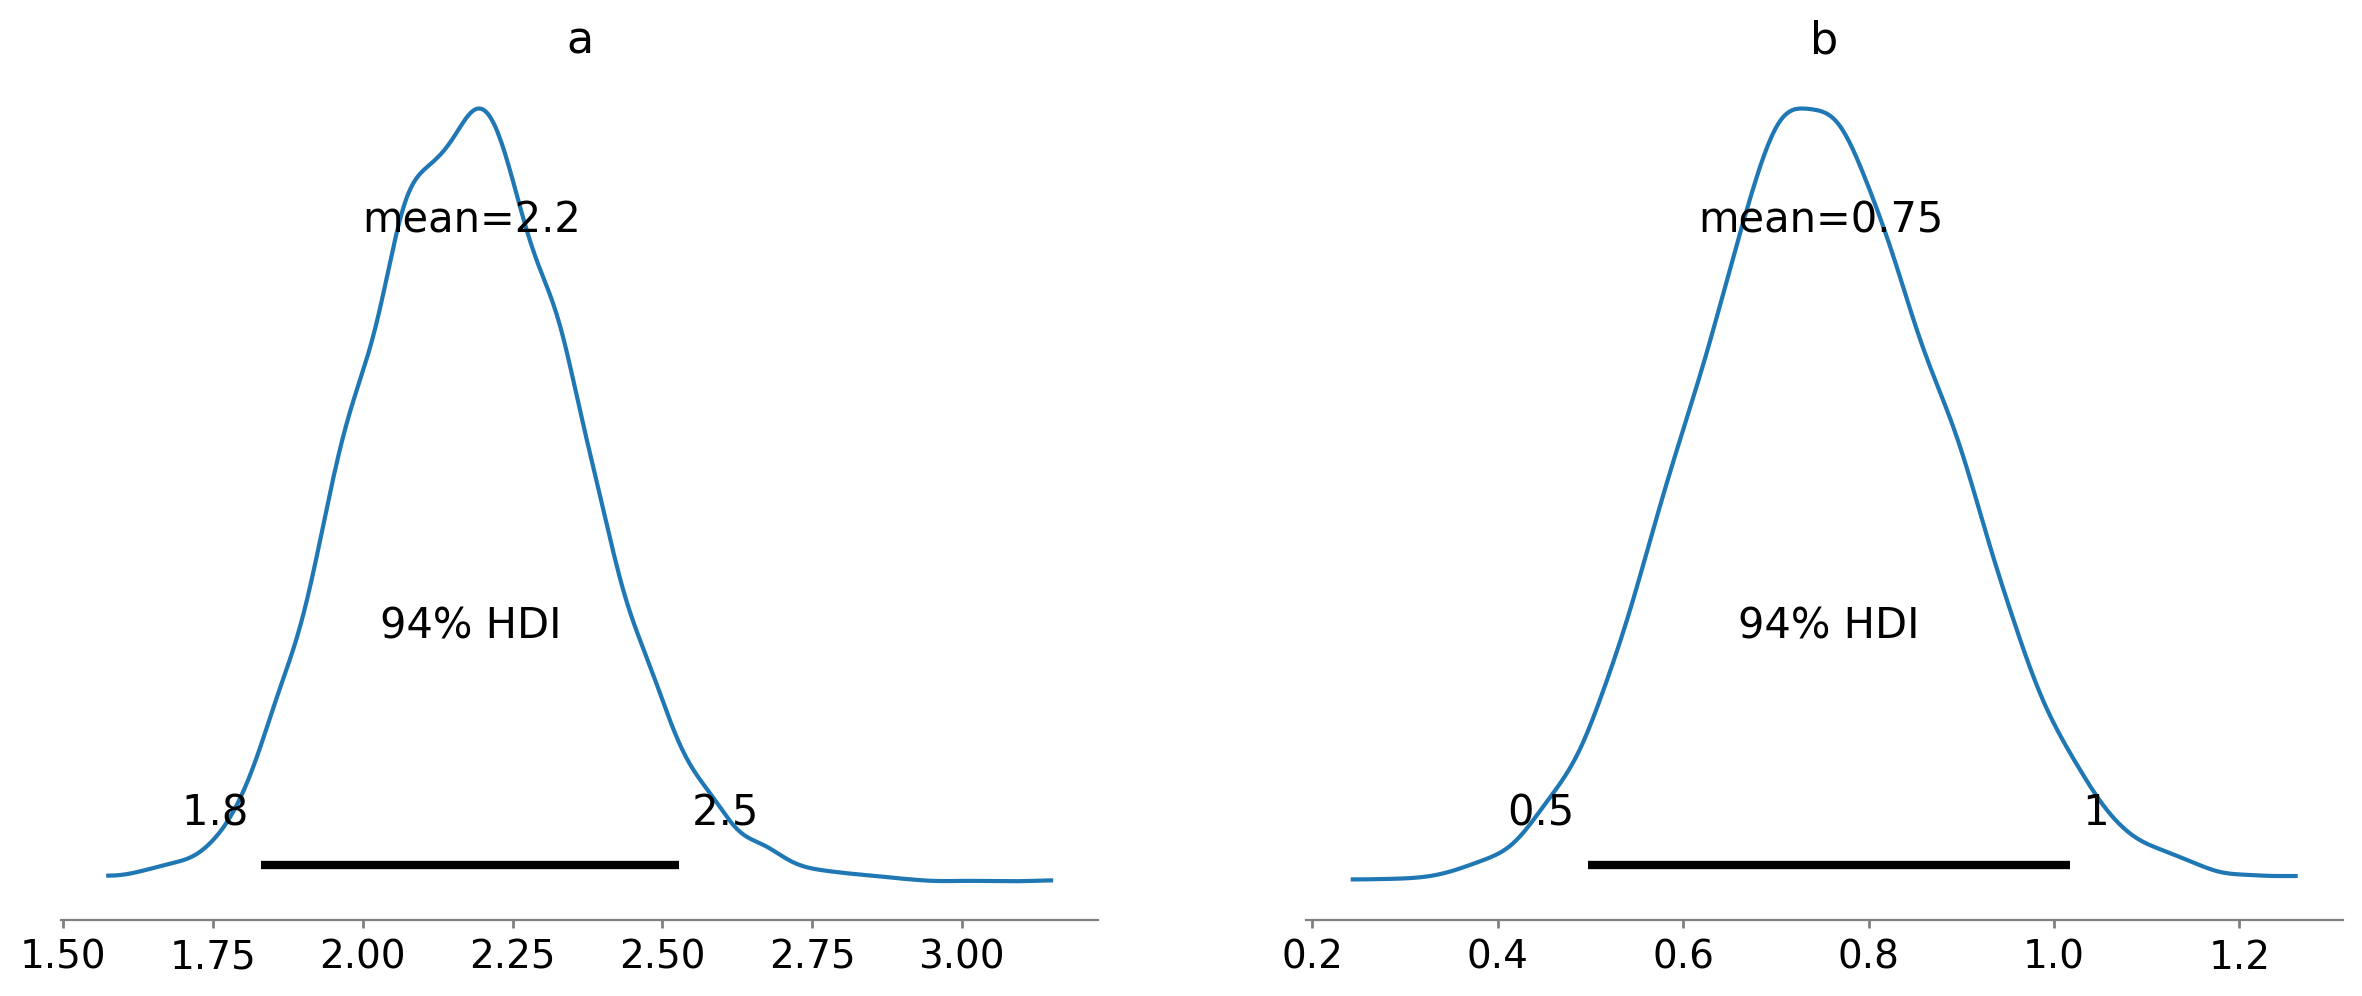

In [14]:
az.plot_posterior(idata)

## 疑問
これも動くじゃん？

In [15]:
jax.nn.sigmoid(gas_scaled)

Array([0.16410704, 0.25028834, 0.35302052, 0.4635156 , 0.57035077,
       0.6657423 , 0.744773  , 0.8074996 ], dtype=float32)

なんで、わざわざこうしてる（線形予測子）が必要になるの？

In [16]:
a = 1
b = 3
jax.nn.sigmoid(a * gas_scaled + b)

Array([0.797706  , 0.8702222 , 0.9163849 , 0.94551486, 0.96385086,
       0.9756124 , 0.98322463, 0.9882704 ], dtype=float32)

### ChatGPT 確認

> 上のコードに関連して、なんでわざわざ線形予測子が必要なの？<br>
> そのまま gas_scaled でモデル組めばいいと思ったのだけど違う？

線形予測子を使用する主な理由は、応答変数（ここでは `deaths`）と予測子（`gas_scaled`）との間に線形関係があるという仮定がモデリングに含まれているからです。<br>
線形予測子 `mu` は `gas_scaled` の線形関数として定義されており、パラメータ a と b を介してモデルの柔軟性を提供します。

+ **パラメータ a（傾き）**:
    + これにより、`gas_scaled` の変化が `deaths` にどの程度影響するかを決定します。
    + もし a が 0 に近ければ、`gas_scaled` は `deaths` にほとんどまたは全く影響しないということになります。
+ **パラメータ b（切片）**:
    + `gas_scaled` が 0 のときの `deaths` の期待値を表します。
    + これにより、モデルは `gas_scaled` が異なるレベルにあるときの基本的な死亡数を調整できます。

直接 `gas_scaled` を使用せずに線形予測子を使用すると、モデルの解釈性が向上し、予測子が応答変数に与える影響をより明確に理解できます。<br>
さらに、データが真に線形関係を持っていない場合でも、線形モデルはしばしば良い近似を提供し、計算上の利便性と安定性を提供します。

ただし、データが非線形関係を示している場合や、より複雑なダイナミクスを持っていると考えられる場合は、線形モデルでは不十分かもしれません。<br>
そのような状況では、多項式項の追加、交互作用項、または別の形の非線形モデリングが必要になることがあります。



> 直接 gas_scaled を使用して、線形予測子を使用しない場合、モデルがどのように間違える可能性があるのか、が理解できないのでその点を詳細に教えて

直接 `gas_scaled` を使用して、線形予測子（線形結合による）を使用しない場合、モデルは以下のような点で不適切になる可能性があります：

1. **関係の形状**:
   + `gas_scaled` と `deaths` 間の関係が単純な比例関係ではない場合（たとえば、曲線的または閾値がある場合）、直接 `gas_scaled` を使用すると、この複雑な関係を捉えることができません。
   + 線形予測子を使用することで、変数間の関係の線形部分をモデル化し、その他の非線形なダイナミクスは活性化関数（ここでは sigmoid 関数）を介してモデル化できます。
1. **予測変数の影響**:
   + a と b のようなパラメータを使用することで、`gas_scaled` の変化が `deaths` に与える影響の度合い（感度）を調整できます。
   + これは、単に `gas_scaled` を使用するだけでは得られない柔軟性をモデルに提供します。
1. **統計的推論**:
    + パラメータ a と b には確率分布が割り当てられており、ベイズ推論を通じてこれらのパラメータの不確実性を考慮に入れます。
    + これにより、モデルの不確実性を量化し、より信頼できる結論を導き出すことができます。
1. **モデルの適合性と過剰適合**:
   + 線形予測子を使用することで、モデルはデータのパターンを学習する適切な柔軟性を持ちながらも、過剰適合を避けることができます。
   + 直接 `gas_scaled` を使うと、モデルがデータのノイズに過度に適合してしまう恐れがあります。

要するに、線形予測子を使用することでモデルは、データの基本的な傾向を把握しつつも、それを統計的に解釈しやすく、また計算上も効率的にするための柔軟性と構造を提供します。<br>
これは特に、ベイズ統計モデルにおいて重要であり、不確実性を定量化し、事後分布を通じて推論を行うことが目的です。

> つまり、直接 gas_scaled を使用するということは、単純に「gas_scaled の値を対数変換した数値が deaths の二項分布における発生確率である、と言っているのと同義ということか？であれば理解できたと思うが、違っていたら指摘して欲しい。


はい、その理解で正しいですが、いくつかのニュアンスがあります。<br>
`gas_scaled` を直接使用すると、`deaths` の発生確率は `gas_scaled` の値に直接依存しますが、対数変換ではなくシグモイド関数を通して変換される点が異なります。<br>

モデルで行っているのは、線形予測子 `mu`（`a * gas_scaled + b`）を計算し、その後で `mu` をシグモイド関数に通すことにより、0と1の間の確率（`theta`）を生成しています。シグモイド関数は、線形予測子を [0, 1] の範囲に制限するために使用され、これは二項分布の成功確率に適しています。

直接 `gas_scaled` を使う場合、`gas_scaled` の値がそのままシグモイド関数に入力され、出力された値が二項分布のパラメータとして使用されます。<br>
このアプローチでは、`gas_scaled` の単位の変化が直接的に確率の変化に対応しますが、線形予測子を介してパラメータ a と b を導入することで、`gas_scaled` の変化が `deaths` に与える影響の大きさを制御できるようになります。

要するに、`gas_scaled` を直接使うと、その値の変化が直接二項分布の確率に影響を与えることになり、モデルの予測は `gas_scaled` のスケールや変化の仕方に非常に敏感になります。<br>
線形予測子を使用すると、この関係を調整し、データに含まれる情報をより柔軟にモデル化できます。

### まとめると
+ 線形予測子をモデルに使用する理由は、応答変数（`deaths`）と予測子（`gas_scaled`）間の潜在的な線形関係を表現し、変数間の関係の線形部分を捉えるためです。
+ これにより、モデルの解釈性が向上し、計算上の利便性も提供されます。

+ 直接 `gas_scaled` を使用する場合、モデルは `gas_scaled` と `deaths` 間の非線形関係や複雑なダイナミクスを捉えることができなくなります。
+ 線形予測子は、シグモイド関数を通じて[0, 1]の範囲に確率を制限し、二項分布の成功確率を適切に表現するために使用されます。
+ aとbをモデルに導入することで、`gas_scaled` の変化が `deaths` に与える影響の程度をより適切に制御し、統計的推論における不確実性を考慮し、過剰適合を避けることができます。

+ 簡単に言えば、`gas_scaled` を直接使うと、その変化が二項分布の確率に直接影響を与え、モデル予測が `gas_scaled` の変動に敏感になりますが、線形予測子を使用すると、データの情報をより柔軟にモデル化し、関係を適切に調整できます。